# H12 calibration

This notebook determines the appropriate window size to use for each population. The goal is to find a window size which provides a good signal-to-noise ratio. Larger window sizes will have better specificity (less noisy), at the expense of some sensitivity. However, we are mostly interested in the very strongest signals, and so we err towards specificity.

In the calibration analysis below, we aim to find a window size where the mean haplotype diversity across Chromosome 3 is greater than 0.99, and where the standard deviation is less than 0.15.

In [1]:
%run setup.ipynb

In [2]:
list(pop_defs)

['ao_col',
 'bf_col',
 'bf_gam',
 'ci_col',
 'cm_sav_gam',
 'fr_gam',
 'ga_gam',
 'gh_col',
 'gh_gam',
 'gm',
 'gn_gam',
 'gq_gam',
 'gw',
 'ke',
 'ug_gam']

In [3]:
for pop, config in pop_defs.items():
    print(pop, 
          len(df_haps_a.query(config['query'])))

ao_col 156
bf_col 150
bf_gam 184
ci_col 142
cm_sav_gam 192
fr_gam 48
ga_gam 138
gh_col 110
gh_gam 24
gm 130
gn_gam 80
gq_gam 18
gw 182
ke 96
ug_gam 224


In [7]:
@functools.lru_cache(maxsize=None)
def compute_haplotype_diversity(seq_id, window_sizes, pop, downsample=50, seed=42):
    loc_haps = df_haps_a.query(pop_defs[pop]['query']).index.values
    if len(loc_haps) > downsample:
        np.random.seed(seed)
        loc_haps = np.random.choice(loc_haps, size=downsample, replace=False)
        loc_haps.sort()
    gt = allel.GenotypeDaskArray(callset_haps[seq_id]['calldata/GT'])
    ht = gt.to_haplotypes()
    ht_pop = ht.take(loc_haps, axis=1).compute()
    hh = list()
    for window_size in window_sizes:
        h = allel.moving_haplotype_diversity(ht_pop, size=window_size)
        hh.append(h)
    return hh

In [216]:
def calibrate(pop, window_sizes, min_h=.99, max_h_std=.015, downsample=50, seed=42):
    
    # run computations
    hh_3R = compute_haplotype_diversity('3R', window_sizes, pop, downsample=downsample, seed=seed)
    hh_3L = compute_haplotype_diversity('3L', window_sizes, pop, downsample=downsample, seed=seed)
    hh = [np.concatenate([hr, hl]) for hr, hl in zip(hh_3R, hh_3L)]
    means = [np.mean(h) for h in hh]
    medians = [np.median(h) for h in hh]
    stds = [np.std(h) for h in hh]
    iqrs = [scipy.stats.iqr(h, rng=(50, 100)) for h in hh]

    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(9, 7), facecolor='w', sharex=True)
    
    # plot means
    ax = axs[0]
    x = window_sizes
    y = means
    y2 = medians
    ax.plot(x, y, lw=3, label='mean(H)')
    ax.plot(x, y2, lw=3, label='median(H)')
    ax.set_ylabel('H')
#     ax.set_xlabel('Window size (no. SNPs)')
    ax.set_title(f"{pop_defs[pop]['label']}")
    ax.set_ylim(0.85, 1.03)
    ax.axhline(min_h, color='k', linestyle='--')
    ax.set_xlim(window_sizes[0]/2, window_sizes[-1]*2)
    ax.set_xscale('symlog')
    ax.set_xticks(window_sizes)
    ax.set_xticklabels([])
    ax.grid()
    x = means
    y = window_sizes
    try:
        min_window_size = int(scipy.interpolate.interp1d(x, y)(min_h))
        ax.axvline(min_window_size, color='k', linestyle='--')
        ax.text(min_window_size, 0.85, str(min_window_size), va='bottom', ha='left')
    except:
        pass
    ax.legend(loc='upper left')

    # plot stds
    ax = axs[1]
    x = window_sizes
    y = stds
    y2 = iqrs
    ax.plot(x, y, lw=3, label='std(H)')
    ax.plot(x, y2, lw=3, label='iqr(H)')
    ax.set_ylabel('H')
    ax.set_xlabel('Window size (no. SNPs)')
    ax.set_ylim(0, .05)
    ax.axhline(max_h_std, color='k', linestyle='--')
    ax.set_xlim(window_sizes[0]/2, window_sizes[-1]*2)
    ax.set_xscale('symlog')
    ax.set_xticks(window_sizes)
    ax.set_xticklabels(window_sizes, rotation=90)
    ax.grid()
    x = stds
    y = window_sizes
    try:
        min_window_size = int(scipy.interpolate.interp1d(x, y)(max_h_std))
        ax.axvline(min_window_size, color='k', linestyle='--')
        ax.text(min_window_size, 0, str(min_window_size), va='bottom', ha='left')
    except:
        pass
    ax.legend(loc='upper left')

    plt.show()
    

In [217]:
pops = list(pop_defs)
pops

['ao_col',
 'bf_col',
 'bf_gam',
 'ci_col',
 'cm_sav_gam',
 'fr_gam',
 'ga_gam',
 'gh_col',
 'gh_gam',
 'gm',
 'gn_gam',
 'gq_gam',
 'gw',
 'ke',
 'ug_gam']

In [218]:
# initial set of window sizes to try
window_sizes = tuple(np.logspace(2, 4.8, num=20).astype(int))
window_sizes

(100,
 140,
 197,
 276,
 388,
 545,
 765,
 1075,
 1509,
 2119,
 2976,
 4178,
 5867,
 8237,
 11565,
 16237,
 22797,
 32008,
 44939,
 63095)

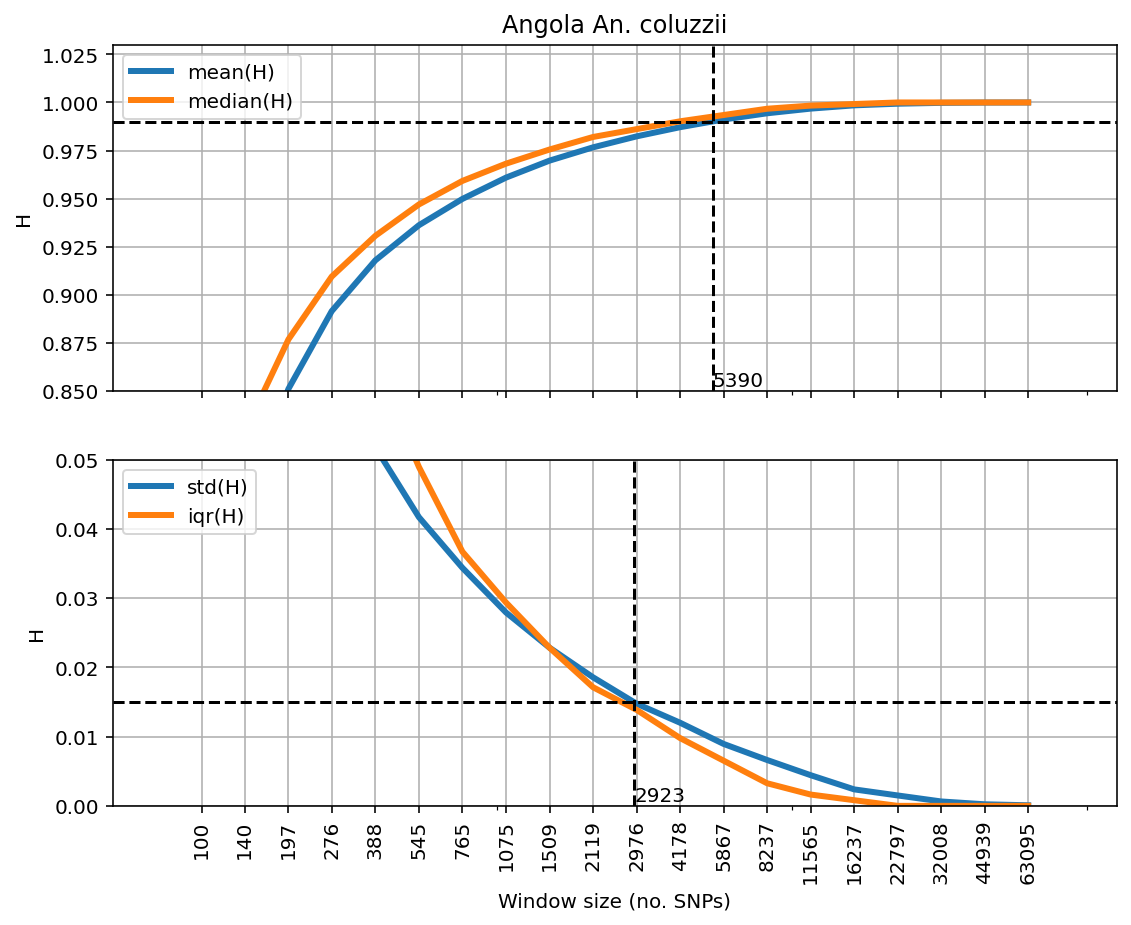

In [219]:
pop = pops[0]
calibrate(pop, window_sizes=window_sizes)
pop_defs[pop]['h12_window_size'] = 6_000

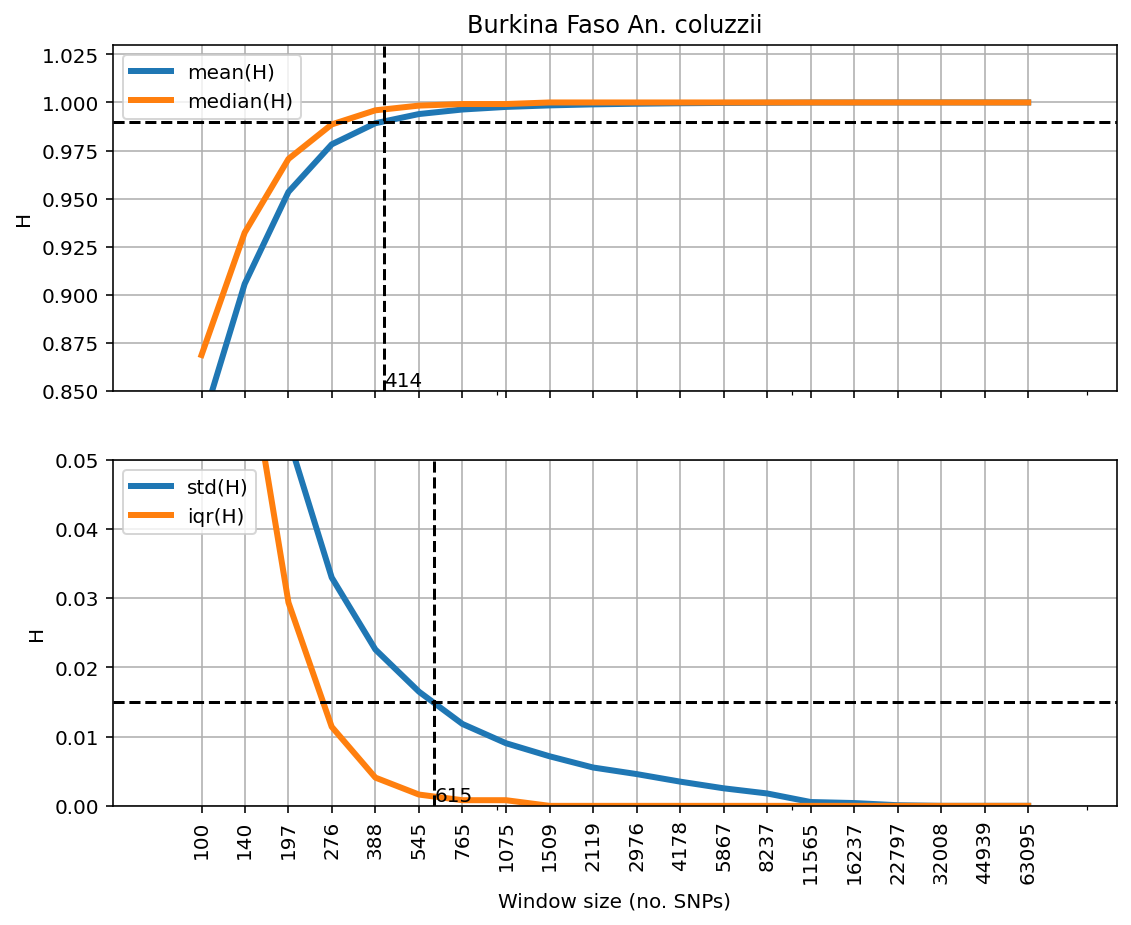

In [220]:
pop = pops[1]
calibrate(pop, window_sizes=window_sizes)
pop_defs[pop]['h12_window_size'] = 1_000

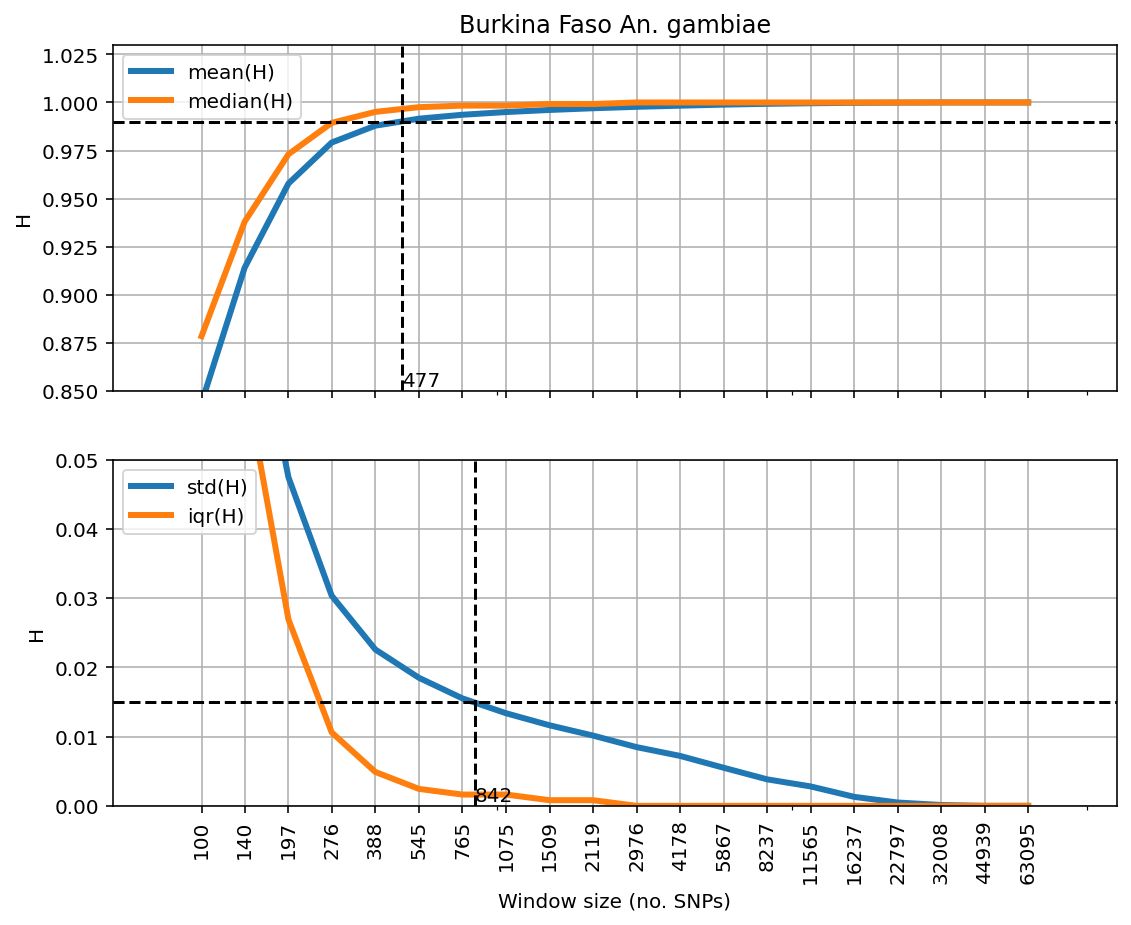

In [221]:
pop = pops[2]
calibrate(pop, window_sizes=window_sizes)
pop_defs[pop]['h12_window_size'] = 1_000

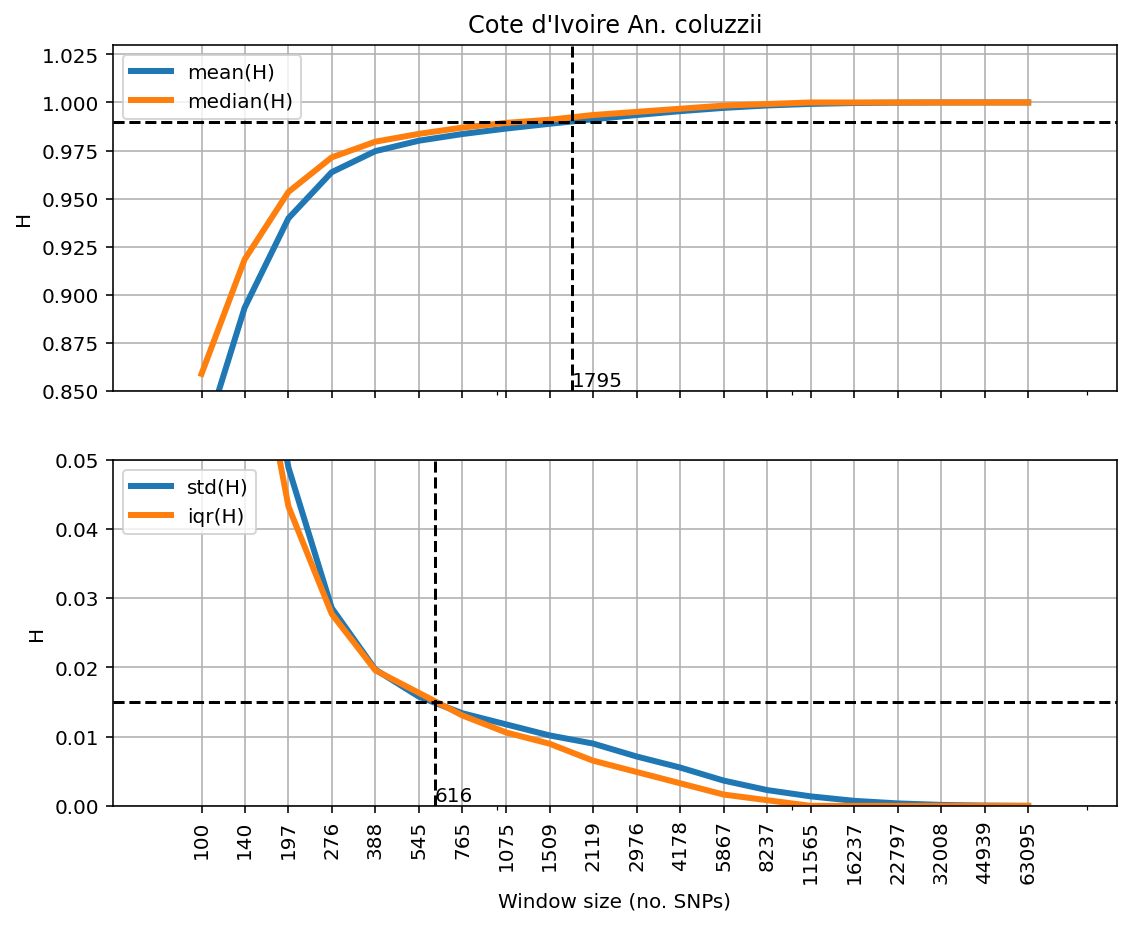

In [222]:
pop = pops[3]
calibrate(pop, window_sizes=window_sizes)
pop_defs[pop]['h12_window_size'] = 2_000

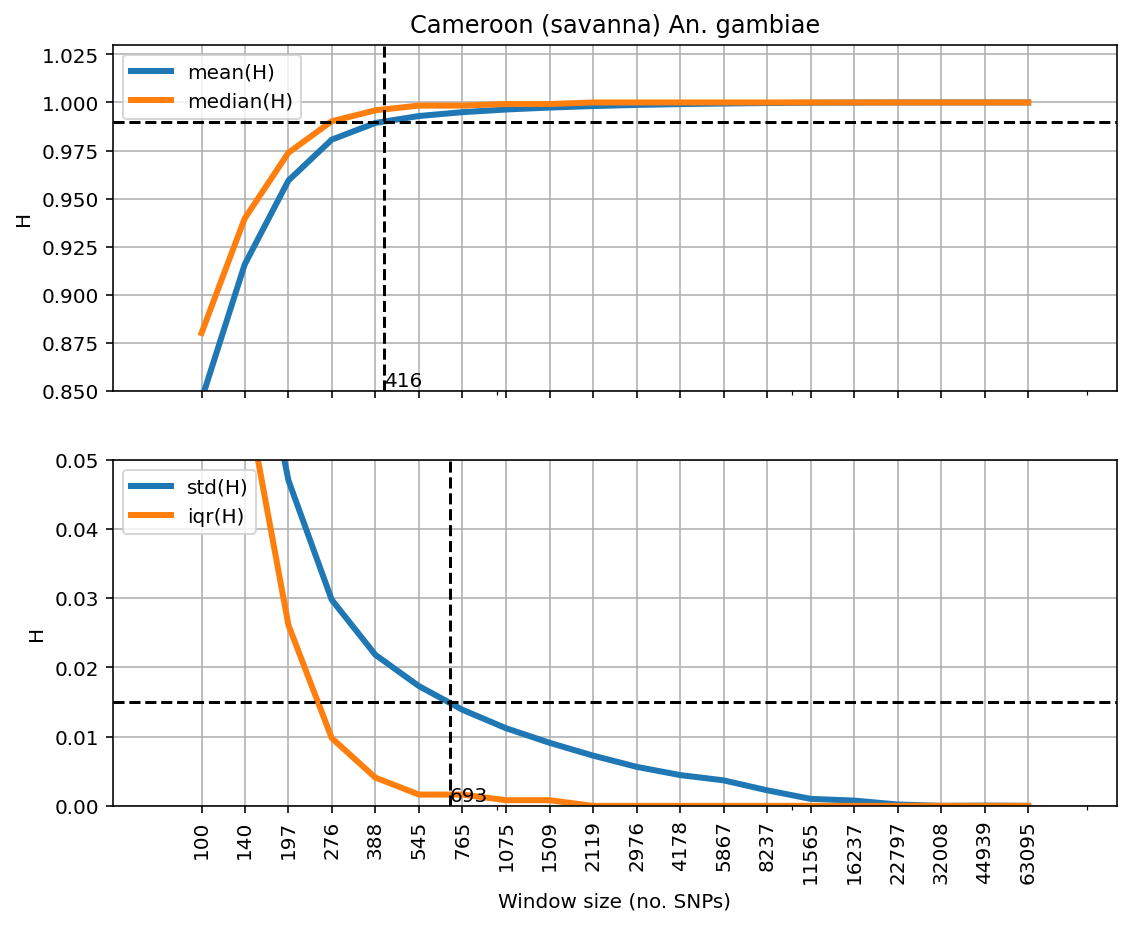

In [223]:
pop = pops[4]
calibrate(pop, window_sizes=window_sizes)
pop_defs[pop]['h12_window_size'] = 1_000

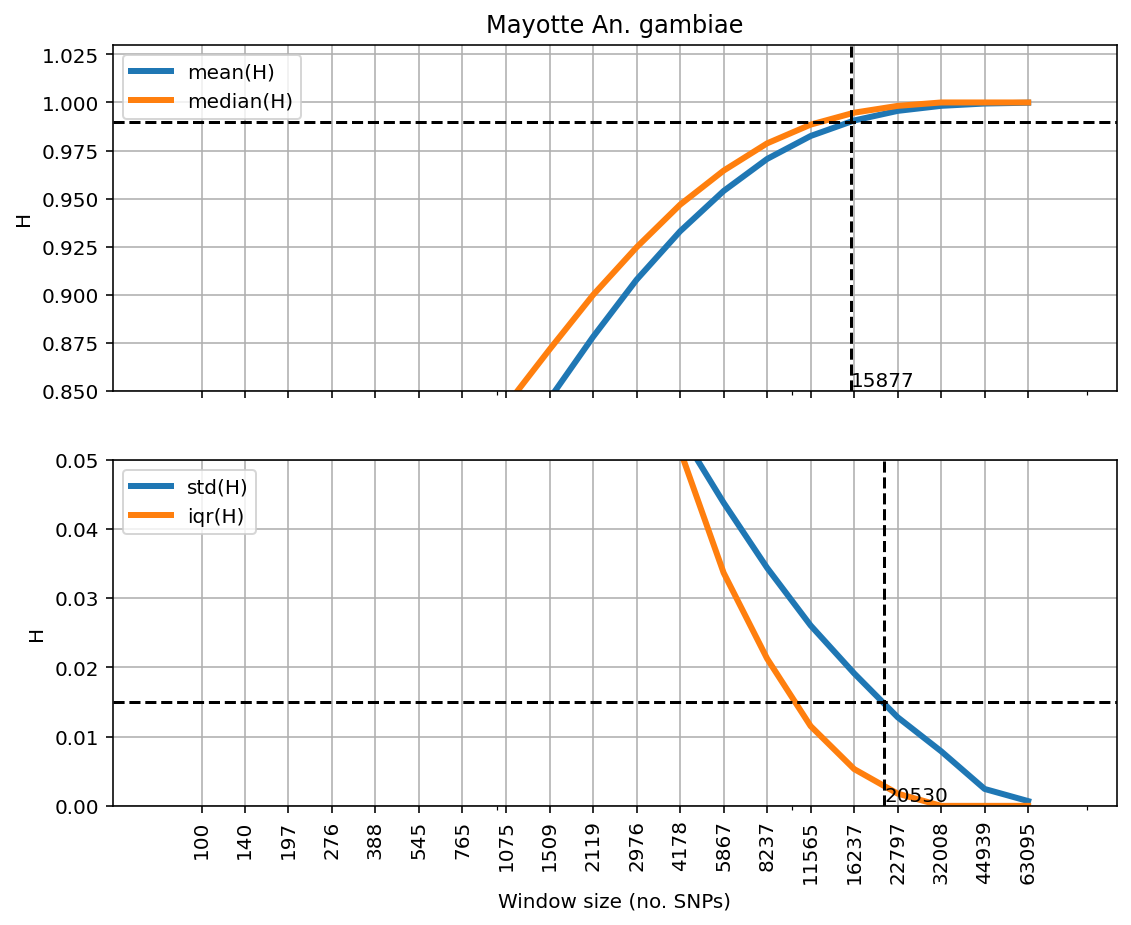

In [224]:
pop = pops[5]
calibrate(pop, window_sizes=window_sizes)
pop_defs[pop]['h12_window_size'] = 16_000

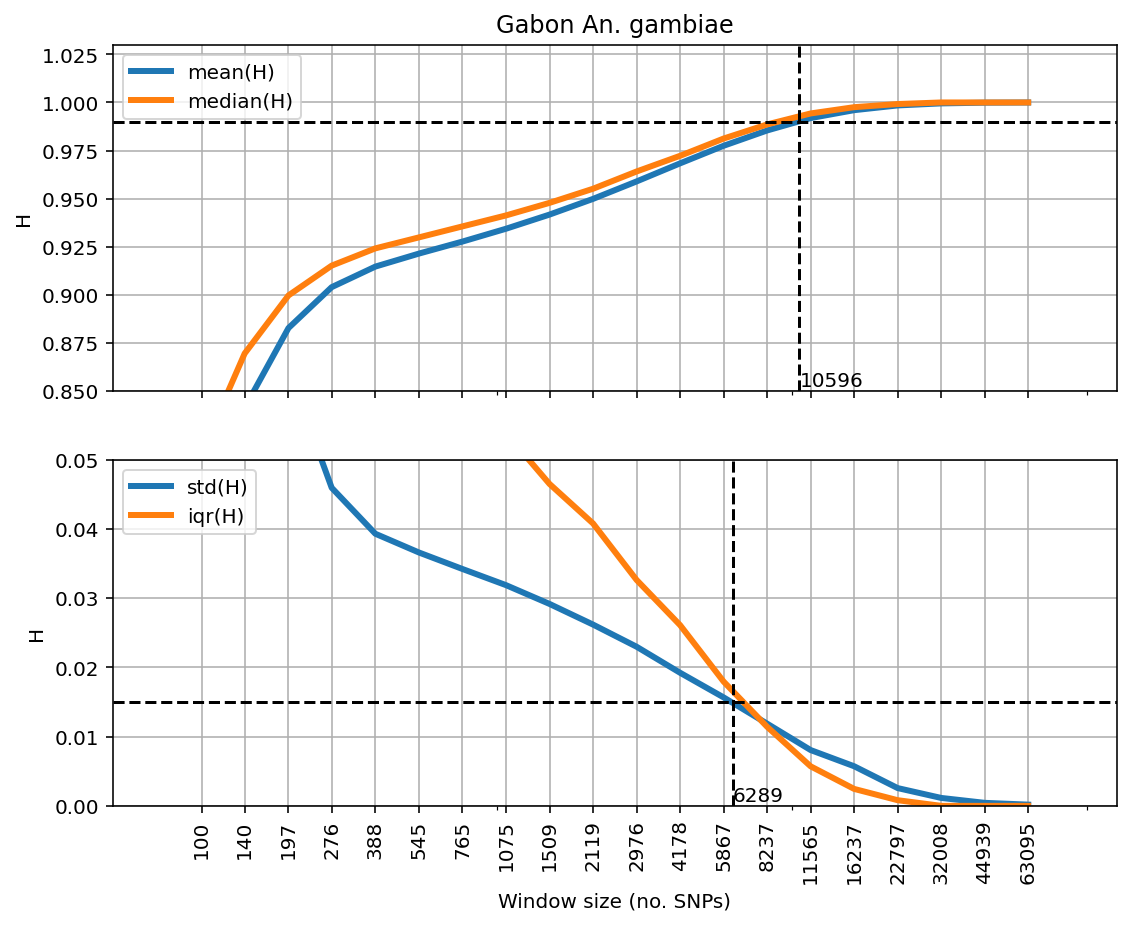

In [225]:
pop = pops[6]
calibrate(pop, window_sizes=window_sizes)
pop_defs[pop]['h12_window_size'] = 10_000

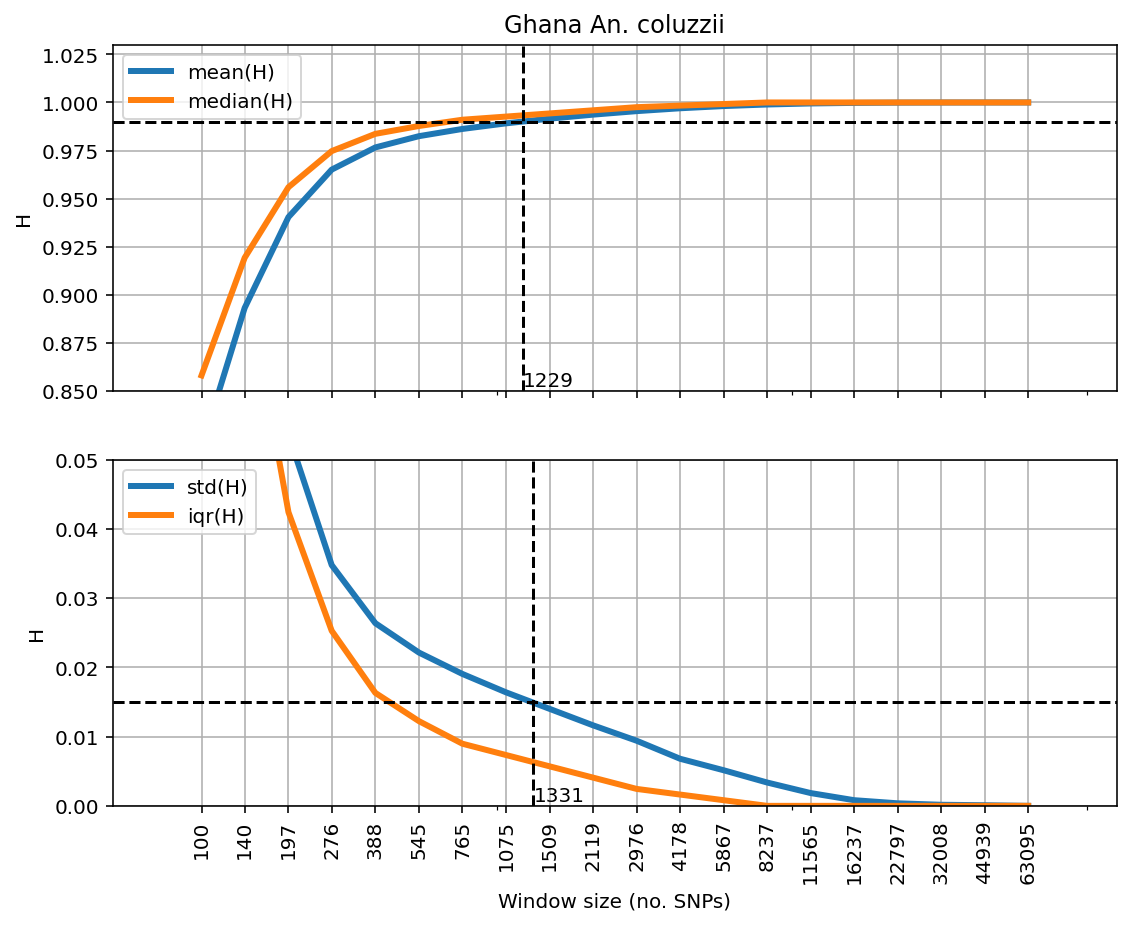

In [226]:
pop = pops[7]
calibrate(pop, window_sizes=window_sizes)
pop_defs[pop]['h12_window_size'] = 1_400

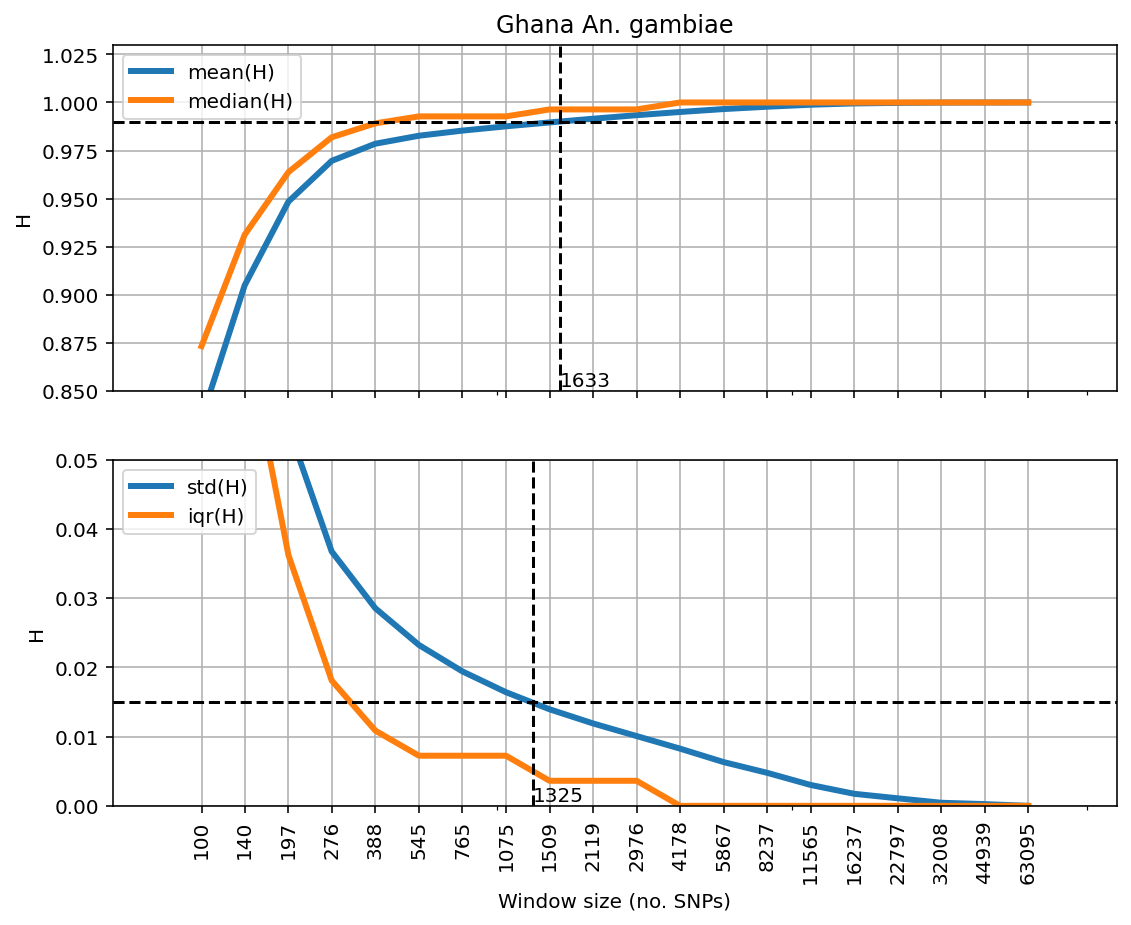

In [227]:
pop = pops[8]
calibrate(pop, window_sizes=window_sizes)
pop_defs[pop]['h12_window_size'] = 1_600

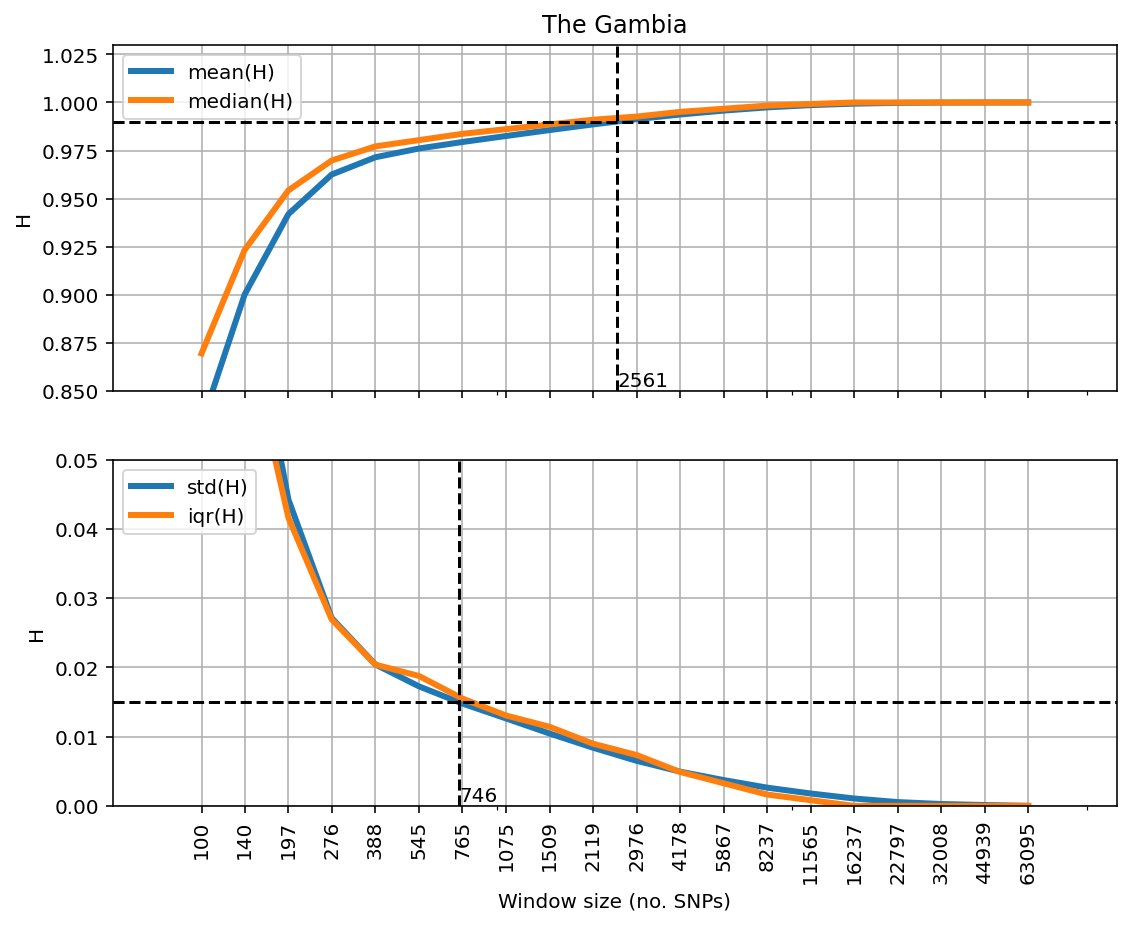

In [228]:
pop = pops[9]
calibrate(pop, window_sizes=window_sizes)
pop_defs[pop]['h12_window_size'] = 2_600

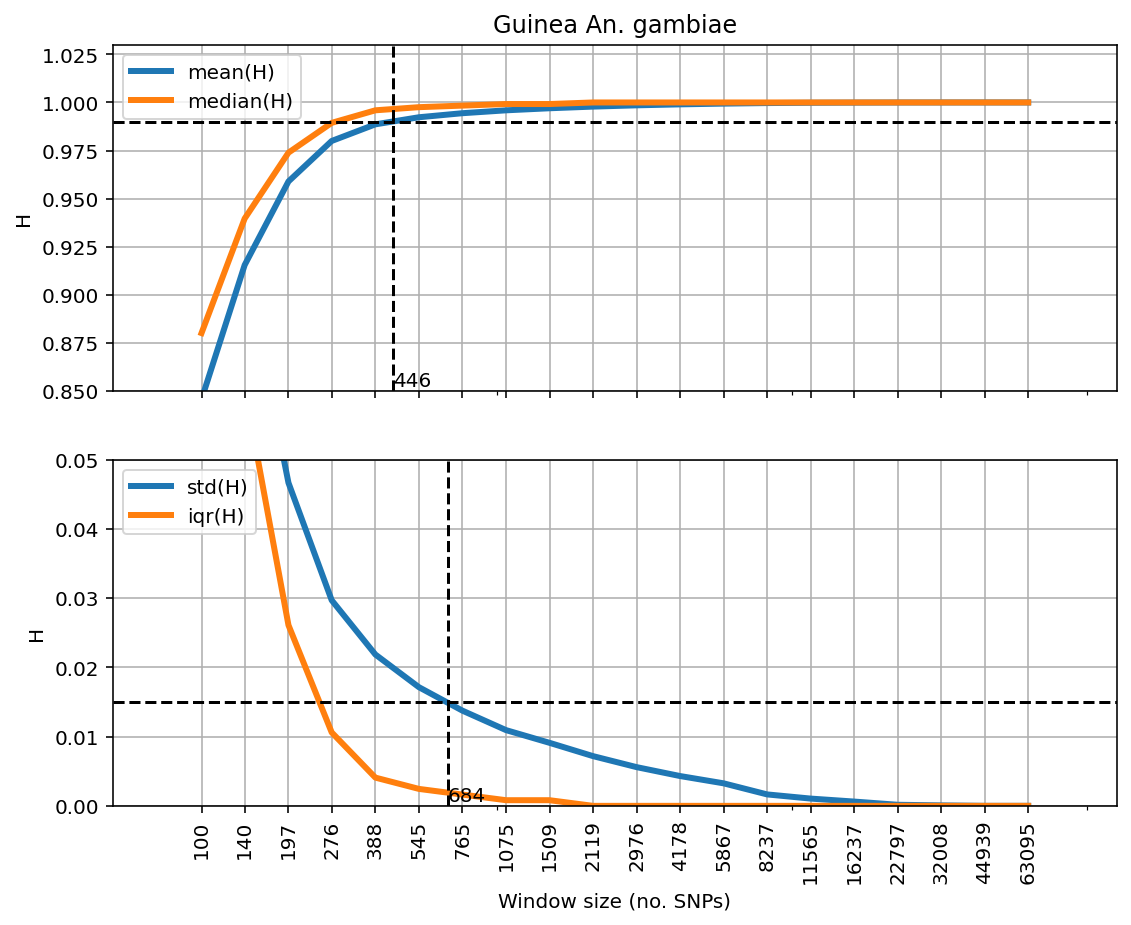

In [229]:
pop = pops[10]
calibrate(pop, window_sizes=window_sizes)
pop_defs[pop]['h12_window_size'] = 1_000

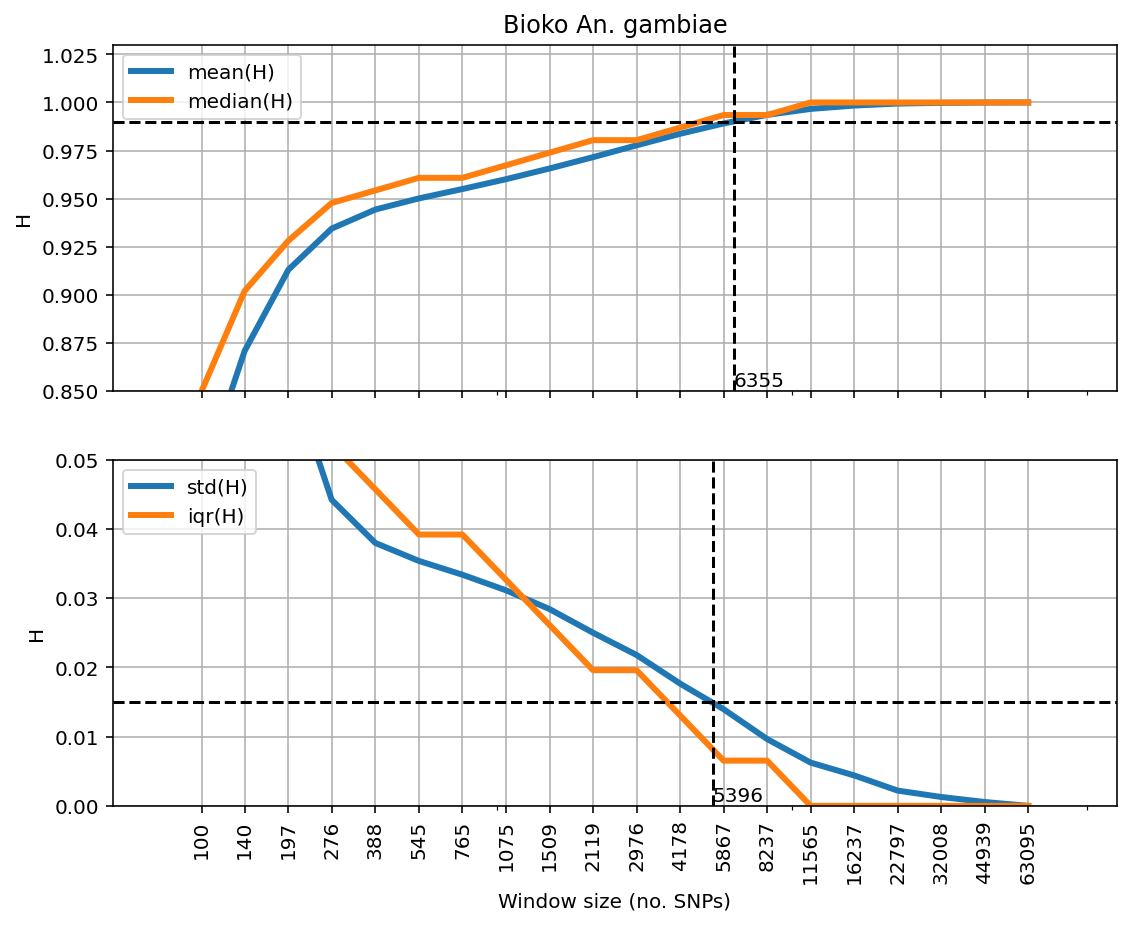

In [230]:
pop = pops[11]
calibrate(pop, window_sizes=window_sizes)
pop_defs[pop]['h12_window_size'] = 7_000

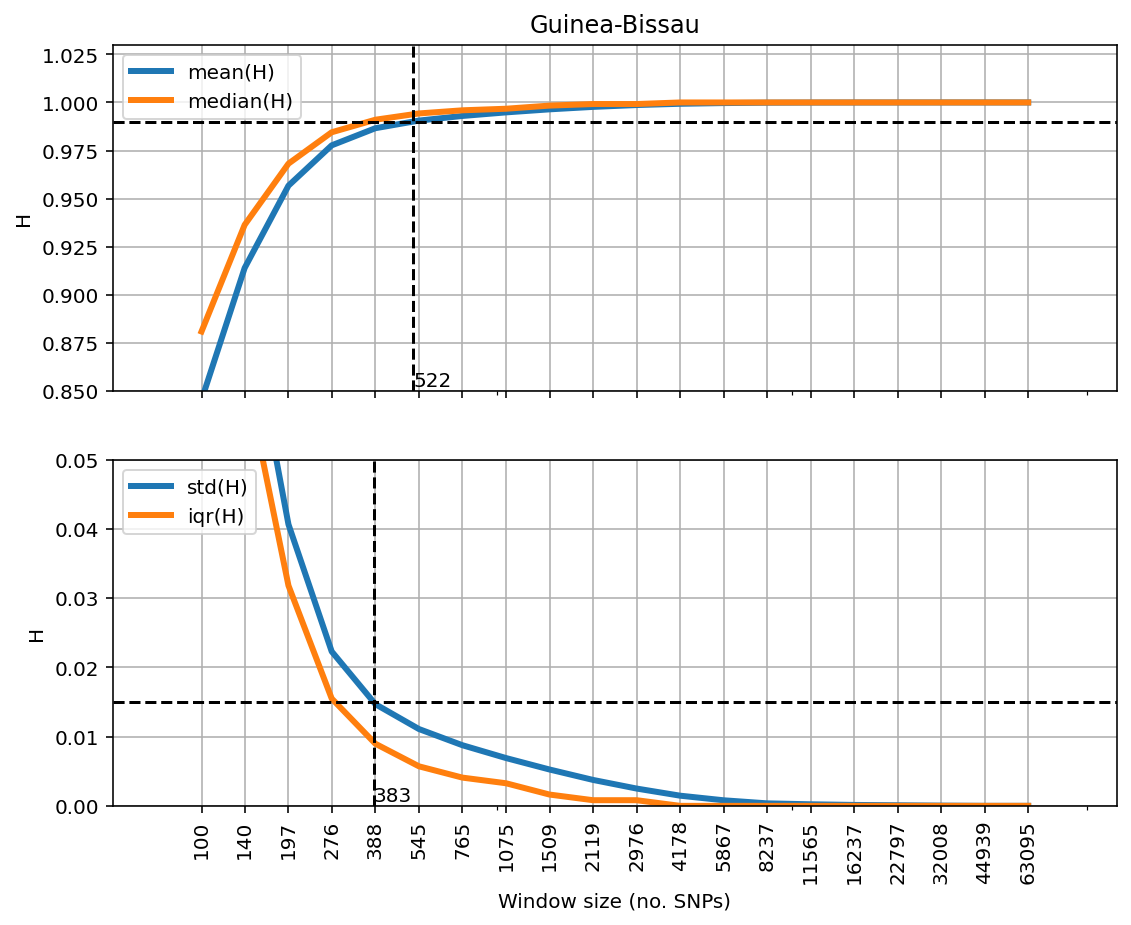

In [231]:
pop = pops[12]
calibrate(pop, window_sizes=window_sizes)
pop_defs[pop]['h12_window_size'] = 1_000

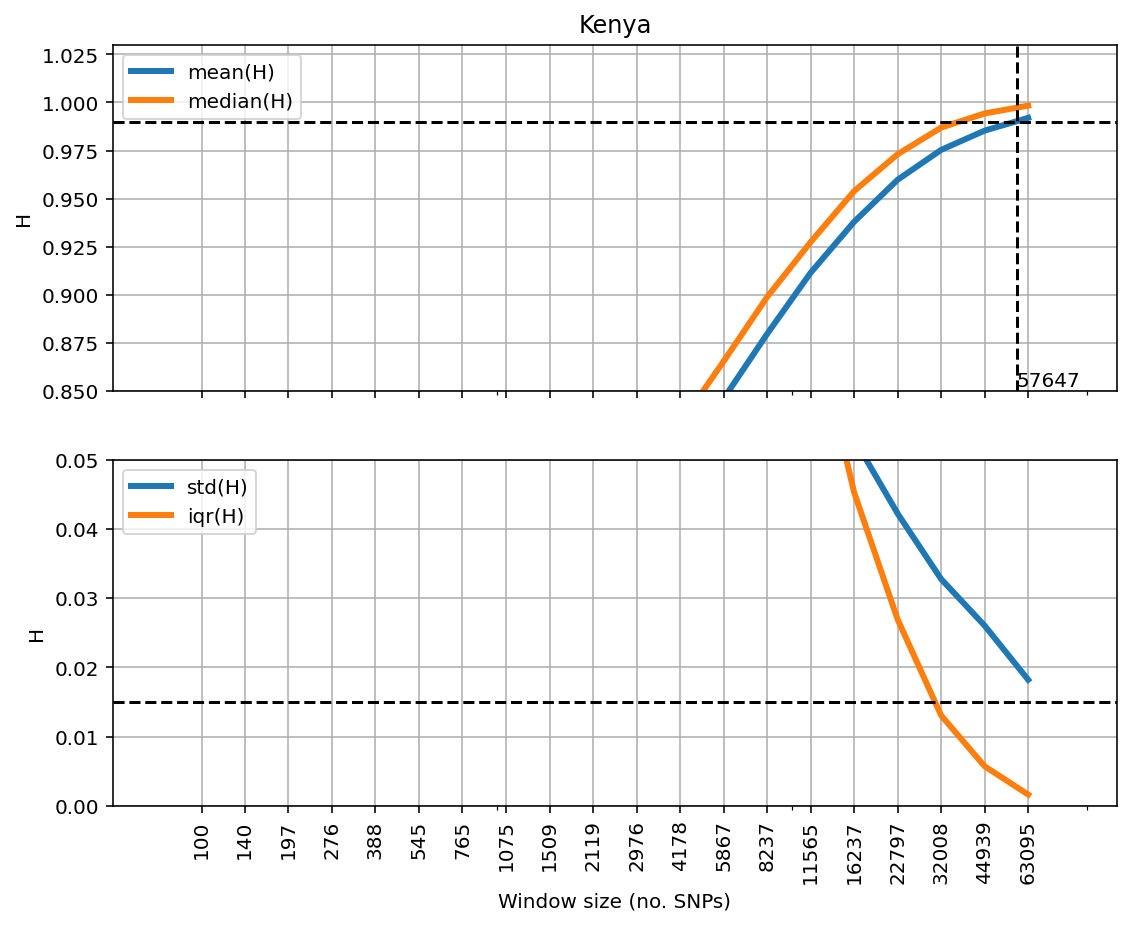

In [232]:
pop = pops[13]
calibrate(pop, window_sizes=window_sizes)
pop_defs[pop]['h12_window_size'] = 60_000

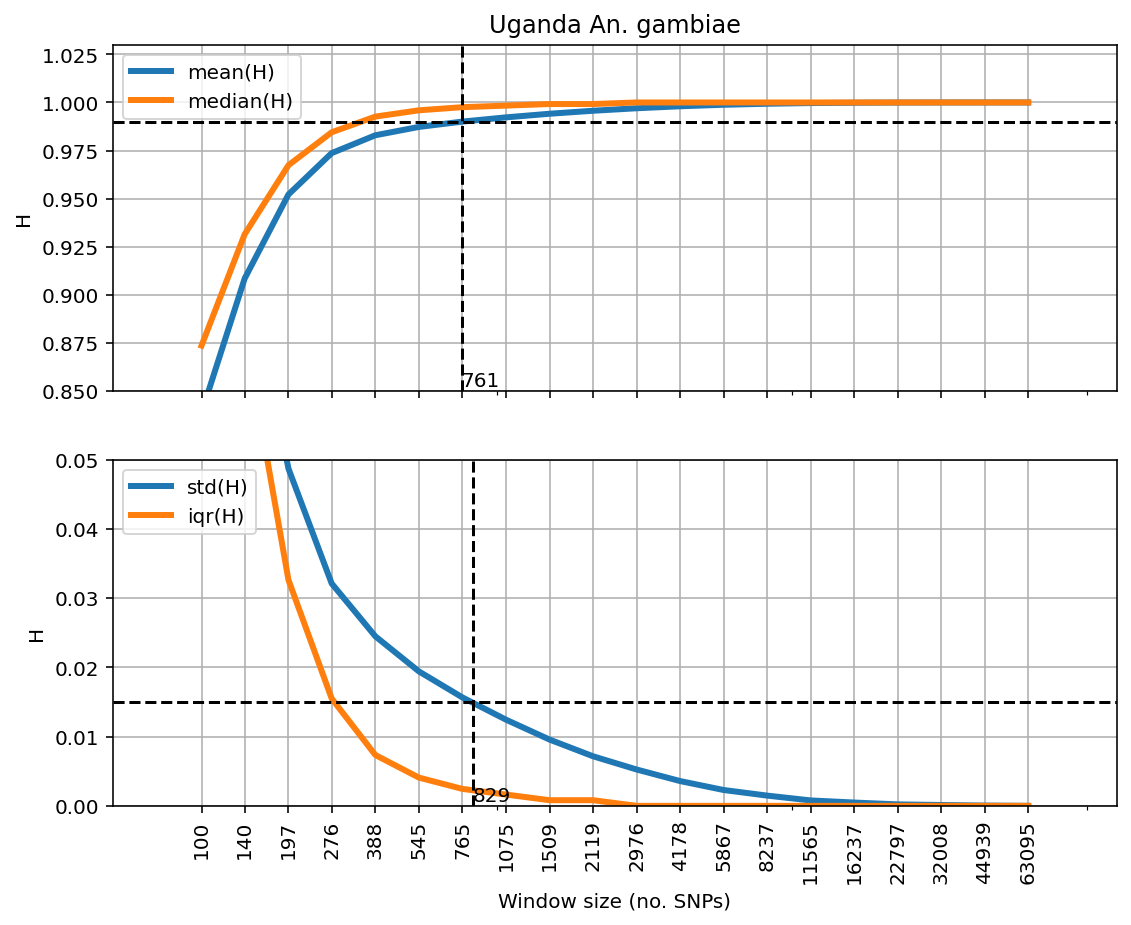

In [233]:
pop = pops[14]
calibrate(pop, window_sizes=window_sizes)
pop_defs[pop]['h12_window_size'] = 1000

In [234]:
with open('pop_defs.yml', mode='w') as f:
    yaml.dump(pop_defs, f)

In [235]:
for pop, config in pop_defs.items():
    print(pop, config['h12_window_size'])

ao_col 6000
bf_col 1000
bf_gam 1000
ci_col 2000
cm_sav_gam 1000
fr_gam 16000
ga_gam 10000
gh_col 1400
gh_gam 1600
gm 2600
gn_gam 1000
gq_gam 7000
gw 1000
ke 60000
ug_gam 1000
